# 프로젝트 : 폐렴 진단기 성능개선

# 목차

**실험 1 : without augment & default learning rate = 0.001  
실험 2 : with augment & default learning rate = 0.001  
실험 3 : with augment & learning rate = 0.0005  
실험 4 : 실험 3 + dropout 삭제  
실험 5 : dropout 삭제 + learning rate**

# (내가 생각한) 학습 목표

+ 딥러닝에서 클래스 불균형을 다루는 방법  
+ 데이터 시각화  

## 딥러닝에서 클래스 불균형을 다루는 방법 

의료 영상 분석은 일반적인 이미지 처리와 다른 점이 많지만  
그 중에서도 음성/양성 데이터간에 불균형이 심한 것이 가장 큰 특징이다.  
이 특징은 학습할 때 영향을 많이 주므로 전처리를 해줘야 한다  
  
그리고 의료 데이터는 특히 예측에 무게가 일반적인 것들과 다르다. 
'정상'이라는 확진이 더 큰 리스크를 수반하기 때문이다  
즉, 모델이 폐렴이라고 예측한 것 중 실제 폐렴 비율인 정확도(Precision)과  
실제 폐렴과 모델이 폐렴이라고 예측한 비율인 재현율(Recall) 모두 중요하다.  
의사 입장에서는 단 한명의 폐렴 환자도 놓치지 않는 것이 가장 중요하기 때문이다  

그런데 이번 데이터는 폐렴 데이터가 정상 데이터보다 3배에 달하는 양이다. 약 페렴 : 정상 = 3 : 1 이라고 볼 수 있다.  
이런 데이터의 불균형은 정확도에는 큰 영향이 없지만 재현율(Recall)에는 많은 영향을 끼친다  
그렇기 때문에 우리는 이 불균형을 **Weight balancing**으로 도울 수 있다.  

이 방법은 특정 클래스에 더 큰 loss값을 주는 방법이다  
여기서는 '정상'이라는 판단이 더 큰 정확도가 필요하므로 'Normal'클래스 데이터에 'Pneumonia'보다 큰 loss를 취할 것이다

## 데이터 시각화 : 코드 해석

```
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16): 
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())
```

>**next(iterator\[, default\])**   
\_\_next\_\_() 메서드를 호출하여 iterator 에서 다음 항목을 꺼냅니다. default 가 주어지면, iterator가 고갈될 때 돌려주고, 그렇지 않으면 StopIteration 을 일으킵니다.  
참조 : https://docs.python.org/ko/3/library/functions.html  
  
>**subplot(nrows, ncols, index)**  
여러개의 그래프를 그릴때 사용  
  
>**plt.axis("off")**  
![](https://frhyme.github.io/assets/images/markdown_img/180619_axis_off.svg)
참조 : https://frhyme.github.io/python-lib/plt_axis_off/

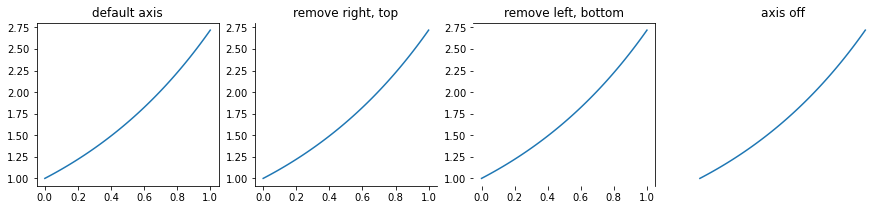

In [1]:
# axis 차이 보기
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 100)
y = np.exp(x)

f, axes = plt.subplots(1, 4, figsize=(15, 3))
axes[0].plot(x, np.exp(x))
axes[0].set_title("default axis")

axes[1].plot(x, np.exp(x))
axes[1].set_title("remove right, top")
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[2].plot(x, np.exp(x))
axes[2].set_title("remove left, bottom")
axes[2].spines['left'].set_visible(False)
axes[2].spines['bottom'].set_visible(False)

axes[3].plot(x, np.exp(x))
axes[3].set_title("axis off")
axes[3].axis('off')

plt.show()

# 실험 1 : Basic (without augment)

## Step 1. 실험환경 Set-up

In [2]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj35/aiffel


## Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.


In [4]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*')) # 와이드카드
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# val 갯수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


val_filenames 개수가 16->1047개로 늘어남

In [6]:
len(filenames)

5232

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1069
Pneumonia images count in training set: 3116


Pneumonia가 훨씬 많은 imbalance data이다  
test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없습니다.    
    
tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.  

In [8]:
# 배치처리 작업을 효율적으로 하게 해줌
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
# Train 데이터 셋, validation 데이터 셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] # 코드 진짜 어렵다
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [11]:
# 라벨 데이터를 만들어 주는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이자  
  
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경  
get_label을 이용해서 라벨 값을 가져옵니다.

In [12]:
def decode_img(img):
    # 이미지를 unit8 tensor로 바꾼다 
    img = tf.image.decode_jpeg(img, channels=3)
    # img를 범위 [0,1]의 float32데이터 타입으로 바꾼다  
    img = tf.image.convert_image_dtype(img, tf.float32)
    # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다 
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path) # 라벨데이터 마듬
    img = tf.io.read_file(file_path)
    img = decode_img(img) # 이미지 사이즈를 줄여줌
    return img, label

train 데이터 셋과 validation 데이터 셋 만들기  
 num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줌

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

shuffle()에  seed인자가 있다.  
일정한 진행을 위해 seed를 고정 시켰다.  
참고 : https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [15]:
# 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환
def prepare_for_training(ds, shuffle_buffer_size=1000, seed=0):
	#shuffle(): 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
	#repeat(): 100개의 데이터를 10번 반복하면 1000개의 데이터를 맞춰줍니다
    ds = ds.repeat()
    
	#100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.
    ds = ds.batch(BATCH_SIZE)
    
	# prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 
    #첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
train_ds # None은 batch 때문에 생긴다

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [16]:
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print('image shape:', image.numpy().shape)
    print('Label:', label.numpy()) # batch가 16개라서  

image shape: (16, 180, 180, 3)
Label: [False False  True  True  True  True  True False  True  True  True  True
  True  True  True False]


In [17]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

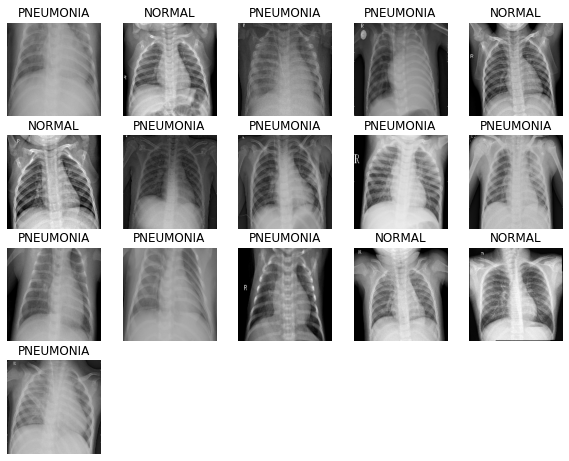

In [18]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16): 
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block=tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리 : weight balancing

폐렴 정보는 많은데 노말에 대한 정보는 적다  
이럴 경우 정상인 것을 판별하는데 있어서 예측성능이 좋지 않아진다  
이런 imbalance를 처리하게 위해서   
**weight balancing**을 해보자  
Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 하는 방법이다  
참조 : https://3months.tistory.com/414  

또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # 'Pneumonia' 이미지에 사용할 weight
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


## Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만,  
optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

Earlystopping도 사용할거다  
Earlystopping클래스의 구성 요소  
>Performance measure: 어떤 성능을 monitoring 할 것인가?  
Trigger: 언제 training 을 멈출 것인가?  

## learnig rate = 0.001

In [23]:
with tf.device('/GPU:0'):
    model_default = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model_default.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True)

In [25]:
with tf.device('/GPU:0'):
    history = model_default.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es, mc],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 30s 116ms/step - loss: 0.3862 - accuracy: 0.7900 - precision: 0.9457 - recall: 0.7617 - val_loss: 0.6822 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 93ms/step - loss: 0.2185 - accuracy: 0.9155 - precision: 0.9772 - recall: 0.9078 - val_loss: 1.1251 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 24s 93ms/step - loss: 0.1995 - accuracy: 0.9289 - precision: 0.9795 - recall: 0.9237 - val_loss: 0.8688 - val_accuracy: 0.7308 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 25s 95ms/step - loss: 0.1684 - accuracy: 0.9363 - precision: 0.9820 - recall: 0.9314 - val_loss: 0.1397 - val_accuracy: 0.9423 - val_precision: 0.9323 - val_recall: 0.9934
Epoch 5/25
261/261 [==============================] - 24s 93ms/step - loss: 0.1619 - accuracy: 

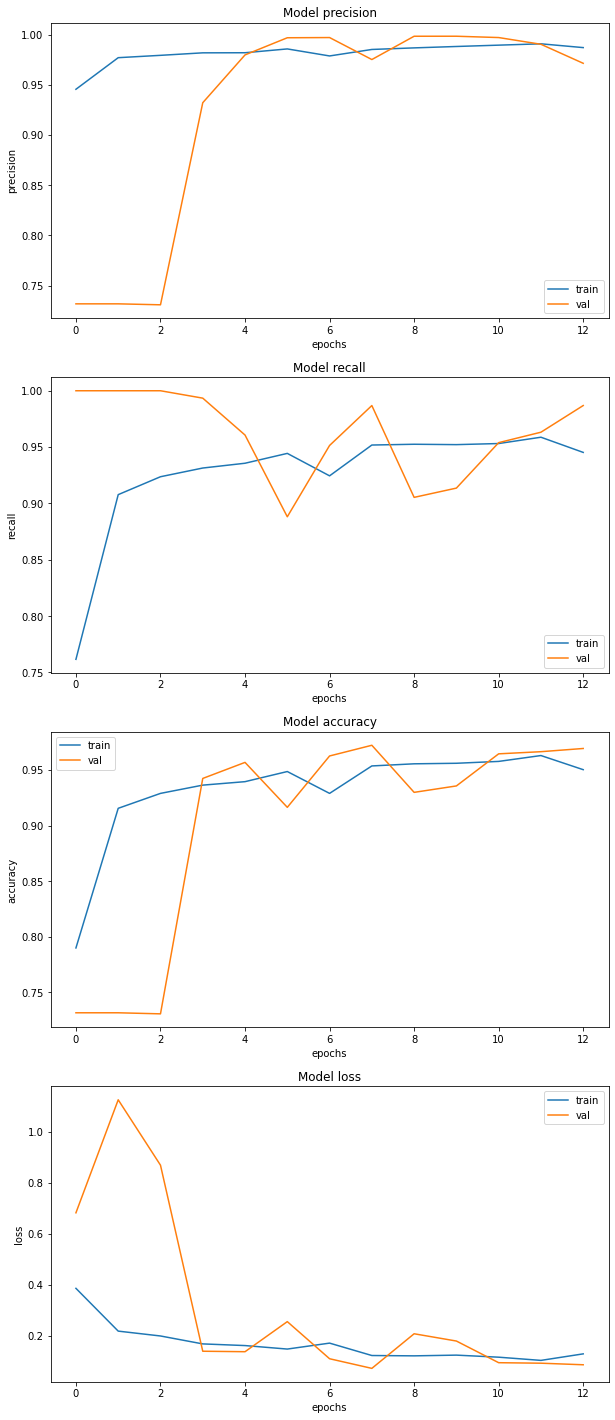

In [26]:
# 결과 확인
fig, ax = plt.subplots(4,1, figsize=(10, 25))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, acc, prec, rec = model_default.evaluate(test_ds)

39/39 [==============================] - 2s 64ms/step - loss: 1.3422 - accuracy: 0.7115 - precision: 0.6842 - recall: 1.0000


# 실험 2 : with augment & learning rate = 0.001

## Step 2. 데이터 준비하기

In [28]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*')) # 와이드카드
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [29]:
# val 갯수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


val_filenames 개수가 16->1047개로 늘어남

In [30]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1062
Pneumonia images count in training set: 3123


In [31]:
# 배치처리 작업을 효율적으로 하게 해줌
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [32]:
# Train 데이터 셋, validation 데이터 셋 갯수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [33]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] # 코드 진짜 어렵다
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [34]:
# 라벨 데이터를 만들어 주는 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이자  
  
process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경  
get_label을 이용해서 라벨 값을 가져옵니다.

In [35]:
def decode_img(img):
    # 이미지를 unit8 tensor로 바꾼다 
    img = tf.image.decode_jpeg(img, channels=3)
    # img를 범위 [0,1]의 float32데이터 타입으로 바꾼다  
    img = tf.image.convert_image_dtype(img, tf.float32)
    # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다 
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path) # 라벨데이터 마듬
    img = tf.io.read_file(file_path)
    img = decode_img(img) # 이미지 사이즈를 줄여줌
    return img, label

train 데이터 셋과 validation 데이터 셋 만들기  
 num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줌

In [36]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
train_ds

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>

In [38]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

# 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환
def prepare_for_training(ds, shuffle_buffer_size=1000, seed=0):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [39]:
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print('image shape:', image.numpy().shape)
    print('Label:', label.numpy()) # batch가 16개라서  

image shape: (16, 180, 180, 3)
Label: [ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True]


In [40]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다.

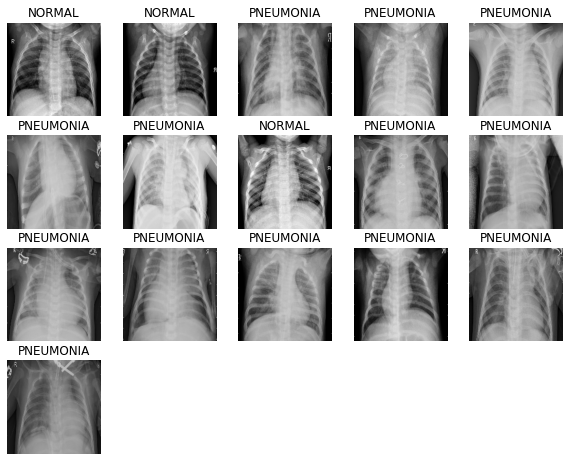

In [41]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16): 
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [42]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [43]:
def dense_block(units, dropout_rate):
    block=tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리 : weight balancing

폐렴 정보는 많은데 노말에 대한 정보는 적다  
이럴 경우 정상인 것을 판별하는데 있어서 예측성능이 좋지 않아진다  
이런 imbalance를 처리하게 위해서   
**weight balancing**을 해보자  
Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 하는 방법이다  
참조 : https://3months.tistory.com/414  

또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [45]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # 'Normal' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # 'Pneumonia' 이미지에 사용할 weight
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


## Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만,  
optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

Earlystopping도 사용할거다  
Earlystopping클래스의 구성 요소  
>Performance measure: 어떤 성능을 monitoring 할 것인가?  
Trigger: 언제 training 을 멈출 것인가?  

## learnig rate = 0.001

In [46]:
with tf.device('/GPU:0'):
    model_default = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model_default.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [47]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True)

In [48]:
with tf.device('/GPU:0'):
    history = model_default.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es, mc],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 27s 102ms/step - loss: 0.4430 - accuracy: 0.7905 - precision: 0.9487 - recall: 0.7602 - val_loss: 0.6048 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2547 - accuracy: 0.8932 - precision: 0.9711 - recall: 0.8833 - val_loss: 0.6924 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2181 - accuracy: 0.9174 - precision: 0.9776 - recall: 0.9100 - val_loss: 0.2978 - val_accuracy: 0.8471 - val_precision: 0.8273 - val_recall: 0.9973
Epoch 4/25
261/261 [==============================] - 26s 101ms/step - loss: 0.1893 - accuracy: 0.9289 - precision: 0.9806 - recall: 0.9231 - val_loss: 0.2257 - val_accuracy: 0.9212 - val_precision: 0.9956 - val_recall: 0.8955
Epoch 5/25
261/261 [==============================] - 27s 102ms/step - loss: 0.1886 - accura

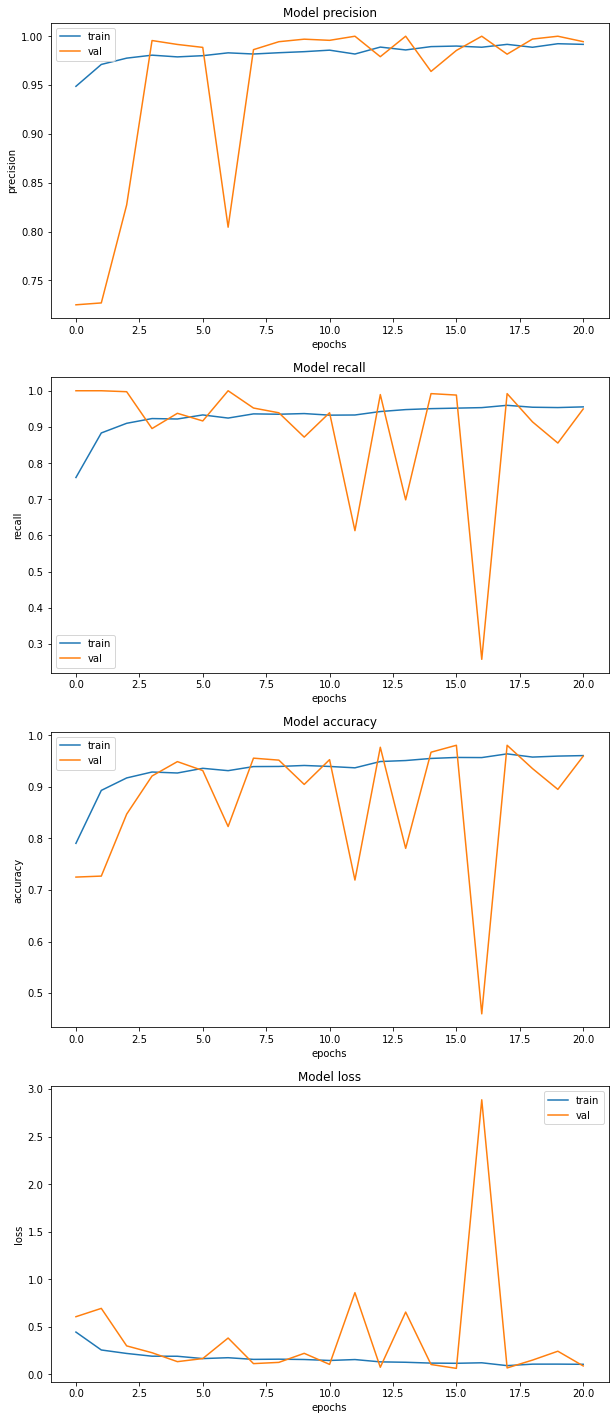

In [49]:
# 결과 확인
fig, ax = plt.subplots(4,1, figsize=(10, 25))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [50]:
loss, acc, prec, rec = model_default.evaluate(test_ds)

39/39 [==============================] - 3s 66ms/step - loss: 0.6390 - accuracy: 0.8317 - precision: 0.7987 - recall: 0.9769


# 실험 3 : with augment & learnig rate = 0.0005

Defaults 값인 0.001 -> 0.0005 로 바꿔서 해보기

In [51]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [52]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True)

In [53]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es, mc],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 25s 96ms/step - loss: 0.4389 - accuracy: 0.7787 - precision: 0.9477 - recall: 0.7446 - val_loss: 0.7182 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 24s 94ms/step - loss: 0.2489 - accuracy: 0.9033 - precision: 0.9738 - recall: 0.8943 - val_loss: 1.4400 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 26s 99ms/step - loss: 0.2106 - accuracy: 0.9176 - precision: 0.9773 - recall: 0.9109 - val_loss: 0.1587 - val_accuracy: 0.9413 - val_precision: 0.9833 - val_recall: 0.9351
Epoch 4/25
261/261 [==============================] - 26s 101ms/step - loss: 0.1905 - accuracy: 0.9255 - precision: 0.9779 - recall: 0.9211 - val_loss: 0.1462 - val_accuracy: 0.9337 - val_precision: 0.9886 - val_recall: 0.9194
Epoch 5/25
261/261 [==============================] - 26s 101ms/step - loss: 0.1812 - accuracy:

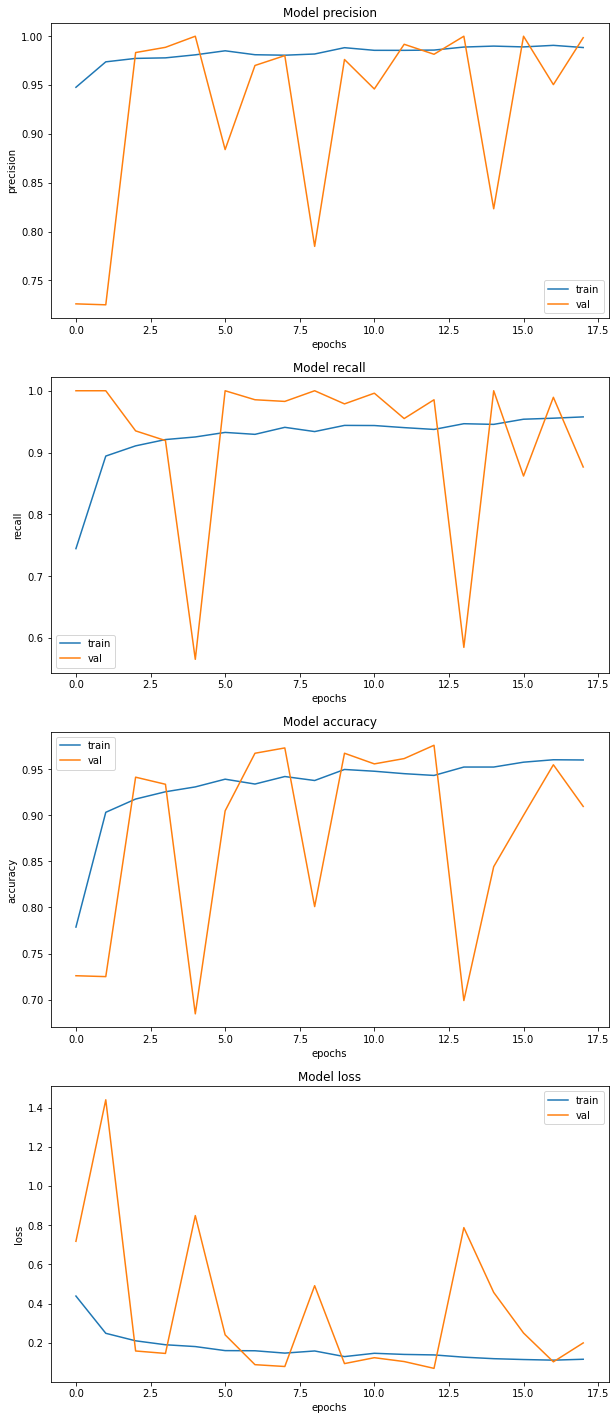

In [54]:
# 결과 확인
fig, ax = plt.subplots(4,1, figsize=(10, 25))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [55]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 63ms/step - loss: 0.3957 - accuracy: 0.8558 - precision: 0.8641 - recall: 0.9128


In [63]:
import pandas as pd

df = pd.DataFrame([
       ['Precision', '0.7115', '0.8317', '0.8558'],
       ['Recall', '1.0000', '0.9769', '0.9128']], columns=['기준', '실험 1', '실험 2', '실험 3'])

df

,기준,실험 1,실험 2,실험 3
0,Precision,0.7115,0.8317,0.8558
1,Recall,1.0000,0.9769,0.9128


augment와 learning rate 변경 후 precision은 계속 증가했지만,   
recall은 계속해서 감소한다 

# 실험 4 : dropout 삭제

In [65]:
def build_model_2nd():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [72]:
with tf.device('/GPU:0'):
    model_2nd = build_model_2nd()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.00005)
    
    model_2nd.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [73]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True)

In [74]:
with tf.device('/GPU:0'):
    history = model_2nd.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es, mc],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 27s 103ms/step - loss: 0.3429 - accuracy: 0.8506 - precision: 0.9574 - recall: 0.8370 - val_loss: 0.7004 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 26s 100ms/step - loss: 0.2228 - accuracy: 0.9222 - precision: 0.9752 - recall: 0.9192 - val_loss: 1.0479 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 26s 101ms/step - loss: 0.1919 - accuracy: 0.9325 - precision: 0.9787 - recall: 0.9296 - val_loss: 0.3714 - val_accuracy: 0.8135 - val_precision: 0.7956 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 26s 100ms/step - loss: 0.1780 - accuracy: 0.9337 - precision: 0.9784 - recall: 0.9316 - val_loss: 0.4443 - val_accuracy: 0.8529 - val_precision: 1.0000 - val_recall: 0.7979
Epoch 5/25
261/261 [==============================] - 25s 97ms/step - loss: 0.1643 - accurac

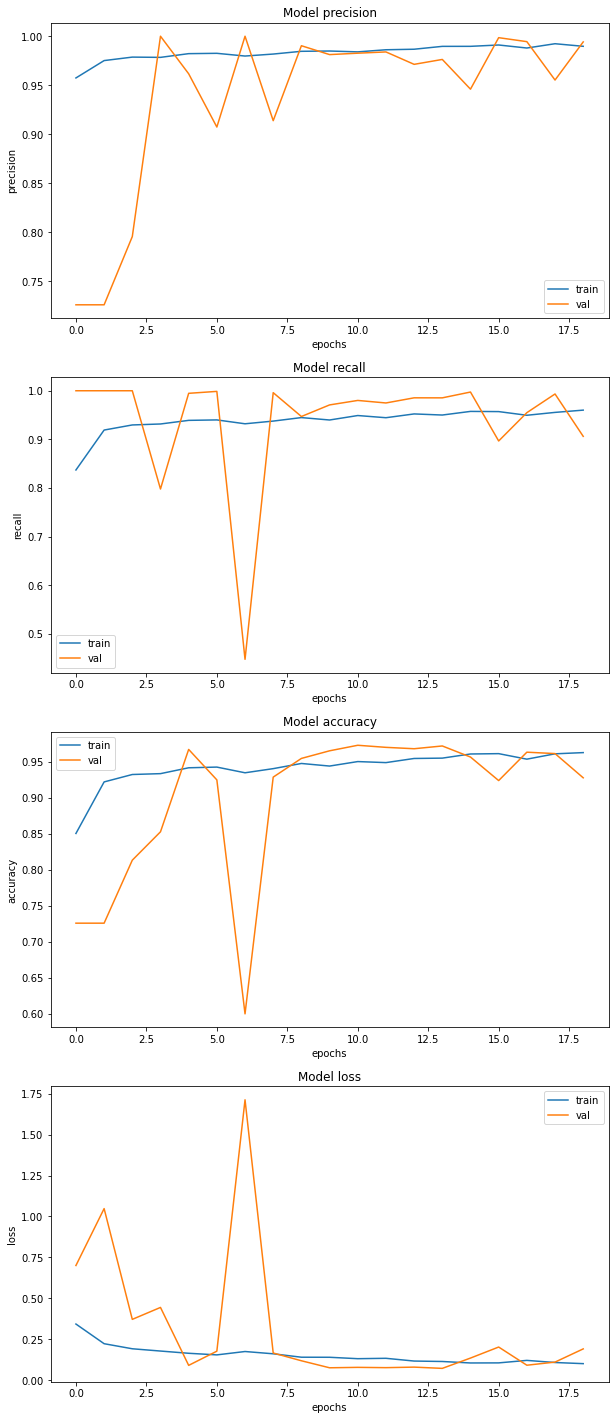

In [75]:
# 결과 확인
fig, ax = plt.subplots(4,1, figsize=(10, 25))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [83]:
loss, acc, prec, rec = model_2nd.evaluate(test_ds)

39/39 [==============================] - 3s 68ms/step - loss: 0.4499 - accuracy: 0.8878 - precision: 0.8774 - recall: 0.9538


# 실험 5 : dropout 삭제 + learning rate = 0.002

In [77]:
def build_model_2nd():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [78]:
with tf.device('/GPU:0'):
    model_3rd = build_model_2nd()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.002)
    
    model_3rd.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [79]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5)

mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='auto', save_best_only=True)

In [80]:
with tf.device('/GPU:0'):
    history = model_3rd.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es, mc],
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 26s 100ms/step - loss: 0.3762 - accuracy: 0.8226 - precision: 0.9545 - recall: 0.8004 - val_loss: 0.7627 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 26s 99ms/step - loss: 0.2161 - accuracy: 0.9188 - precision: 0.9776 - recall: 0.9120 - val_loss: 1.3535 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 27s 104ms/step - loss: 0.1958 - accuracy: 0.9270 - precision: 0.9753 - recall: 0.9255 - val_loss: 0.2327 - val_accuracy: 0.9000 - val_precision: 0.8798 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 26s 100ms/step - loss: 0.1898 - accuracy: 0.9322 - precision: 0.9787 - recall: 0.9294 - val_loss: 0.2929 - val_accuracy: 0.8875 - val_precision: 1.0000 - val_recall: 0.8450
Epoch 5/25
261/261 [==============================] - 26s 100ms/step - loss: 0.1680 - accurac

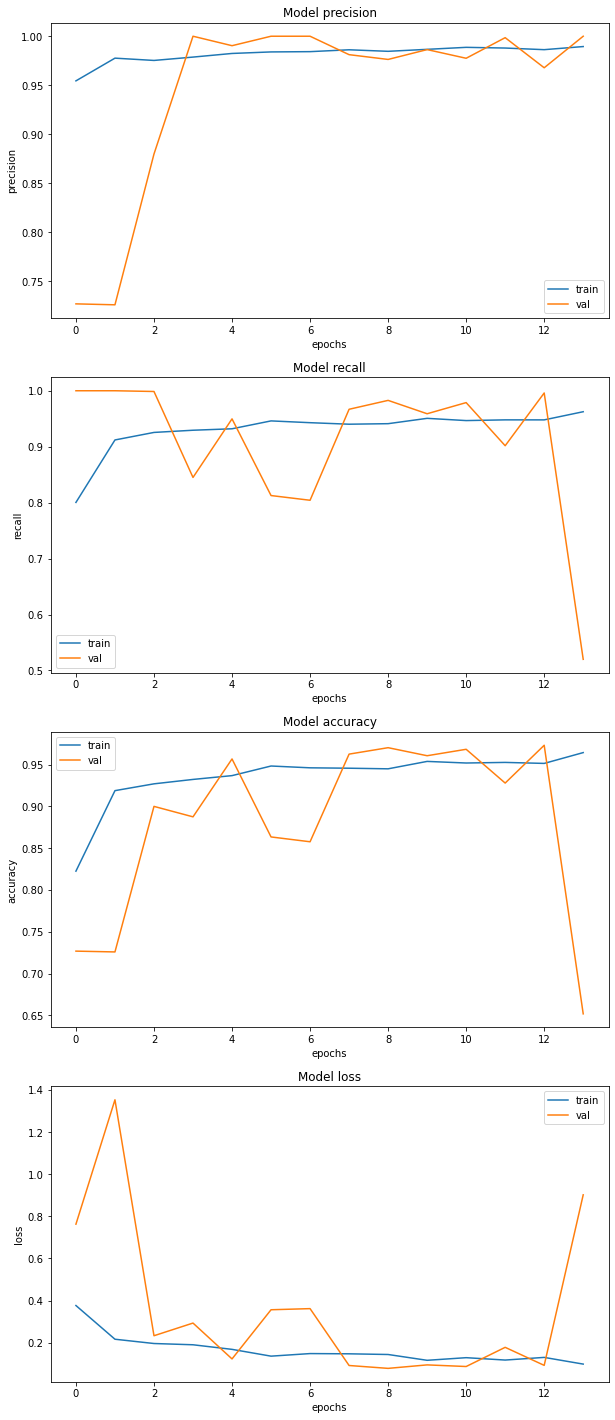

In [81]:
# 결과 확인
fig, ax = plt.subplots(4,1, figsize=(10, 25))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [84]:
loss, acc, prec, rec = model_3rd.evaluate(test_ds)

39/39 [==============================] - 3s 69ms/step - loss: 0.5469 - accuracy: 0.7917 - precision: 0.9545 - recall: 0.7000


# 결과 비교

In [89]:
import pandas as pd

df = pd.DataFrame([
       ['Precision', '0.7115', '0.8317', '0.8558'],
       ['Recall', '1.0000', '0.9769', '0.9128']], columns=['기준', '실험 1', '실험 2', '실험 3'])

ex_4 = ['0.8878', '0.9538']
df['실험 4'] = ex_4

ex_5 = ['0.7917', '0.7000']
df['실험 5'] = ex_5

df

,기준,실험 1,실험 2,실험 3,실험 4,실험 5
0,Precision,0.7115,0.8317,0.8558,0.8878,0.7917
1,Recall,1.0000,0.9769,0.9128,0.9538,0.7000


dropout을 삭제하니까 precision & recall 모두 올라갔다.  
***
learning rate를 올리면(0.001 -> 0.002) recall이 좋아질 줄 알았는데,    
precition & recall 모두 형편없이 떨어졌다   
=> 2배 말고 조금씩 증가하는 방법으로 나중에 해볼 예정이다.

# 루브릭

평가문항
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.  
   모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  
   -> ok
   

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.  
   regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.  
   ablation study 참조 : https://fintecuriosity-11.tistory.com/73  
   -> ok  
   
   
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.  
   Accuracy 기준 85%에 도달하였다.  
   -> ok  

# 회고

imbalance에 대한 해석과 recall 값을 신경써서 전처리 하는 부분이 오랜만에 이해가 잘 돼서 즐거웠다.  
아쉬운 점은 dropout을 삭제했을 때 일어난 현상(precision & recall 모두 성능 좋아짐)에 대한 근거를 알지 못한다는 점이다.  
dropout을 했을 때 성능이 좋아졌던 case에 대해 찾아 봐야겠다.  
또한 이번에도 코드가 어려웠던 부분이 있었는데, 
그래도 열심히 구글링하면서 보았던 부분들이 조금이지만 도움이 되었다.  